In [1]:
import pickle
import os.path
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import torch
from torch import nn
from torch.optim import SGD
from torch.nn import functional as F
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pdb
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#DEVICE = 'cpu'

In [2]:
path = os.getcwd()
with open(path + '/Pickles/word2vec.pkl', 'rb') as file:
    w2v_model = pickle.load(file)
    
with open( path + '/data/W2V.pkl', 'rb') as file:
    X_train, X_val, X_test = pickle.load(file)

with open(path + '/data/yTrainValTest.pkl', 'rb') as file:
    y_train, y_val, y_test = pickle.load(file) 

In [3]:
# standardize the data 

In [4]:

class Perceptron(nn.Module):
    def __init__(self, n_in, n_hi):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hi, bias=True) #n_in: number of input, n_hi(100): number of output
        self.fc2 = nn.Linear(n_hi, 1, bias=True)   # add hidden layer, n_hi(100): number of input, 1
        
    'perceptron() == perceptron.forward()'                 
    def forward(self, x):      # 
        x = self.fc1(x)        # apply first layer to X
        x = F.relu(x)          # apply an activation function
        x = self.fc2(x)        # apply second layer to X
        return x

In [32]:
#perceptron = Perceptron(X_train.shape, 1000)
#optimizer = SGD(perceptron.parameters(), lr=0.01)

In [5]:
mean=np.mean(y_train)
std = np.std(y_train)

In [137]:
X_trai

numpy.ndarray

In [163]:


# for batch in fmnist_dl:
#     break
# for batch in fmnist_dl:
#     break

# print("y:", batch[1].shape)
# print("X: ", batch[0].shape)

In [166]:
y.shape

torch.Size([32])

In [159]:
comb = np.array((list([X_train,y_train])))

ValueError: could not broadcast input array from shape (3783,93,300) into shape (3783)

In [8]:
N_EPOCHS = 5
# init the model, loss and optimizer
net = Perceptron(X_train.shape[1]*X_train.shape[2], 300)
#net.apply(custom_weights)  # applies the custom_weights function: setting weights to zero
optimizer = SGD(net.parameters(), lr=0.05)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
criterion = nn.SmoothL1Loss()
net = net.to(DEVICE)
BATCH_SIZE = 32

mean=np.mean(y_train)
std = np.std(y_train)

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
data = DataLoader(dataset, batch_size=BATCH_SIZE)
batch_iterator = iter(data)

loss_history = []
#%timeit
for epoch in range(N_EPOCHS):
    print("training epoch {}".format(epoch))
   
    for batch in data:
        X_batch,y_batch=batch
    
        for xsample, ysample in zip(X_batch, y_batch):
            optimizer.zero_grad() 
            # zero the gradients
            # batch preparation

            xsample = xsample.reshape(-1)
            ysample = (ysample-mean)/std
            x = torch.Tensor(xsample).unsqueeze(0) # tensor([[0.8745, 0.5205]]) torch.Size([1, 2])
            y = torch.Tensor([ysample]).unsqueeze(0) # tensor([[1.]]) torch.Size([1, 1])
            x = x.to(DEVICE)    # transfers the x to GPU(if available, otherwise CPU -> see Code above)
            y = y.to(DEVICE)

            # forward pass
            out = net(x) # prediction, y_hat, 

            # loss calculation
            loss = criterion(out, y)

            # calculating gradients
            loss.backward()

        # changing the weights by specified(in the optimizer init) learning rate
        optimizer.step()

        #append calculated loss to the history
        loss  = loss.detach().cpu().numpy()
        loss_history.append(loss)


print("input shape (BS, n_classes):", x.shape)
print("target shape (BS, 1):", y.shape)
print("output shape", out.shape)

training epoch 0
training epoch 1
training epoch 2
training epoch 3
training epoch 4
input shape (BS, n_classes): torch.Size([1, 27900])
target shape (BS, 1): torch.Size([1, 1])
output shape torch.Size([1, 1])


Text(0, 0.5, 'loss (CE)')

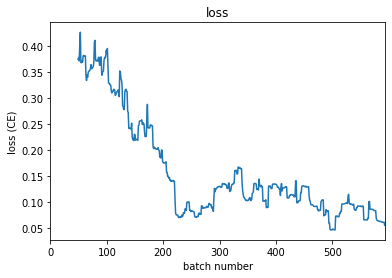

In [9]:
history = pd.DataFrame(loss_history, columns=['loss'])
history.loss[:2500].rolling(50).mean().plot()
plt.title("loss")
plt.xlabel("batch number")
plt.ylabel("loss (CE)")

In [10]:
preds=[]
actual=[]
net.eval()
for instance, label in zip(X_val, y_val):   
    value = torch.Tensor(instance.reshape(-1)).cuda()
    # pass it through the model
    raw_prediction = net(value)
    prediction = raw_prediction*std+mean
    preds.append(prediction)
    actual.append(label)

In [11]:
preds_cpu = [preds[i].cpu() for i in range(len(preds))]

In [12]:
y_pred = np.array([preds_cpu[i].item() for i in range(len(preds_cpu))])
y_true = np.array(actual)

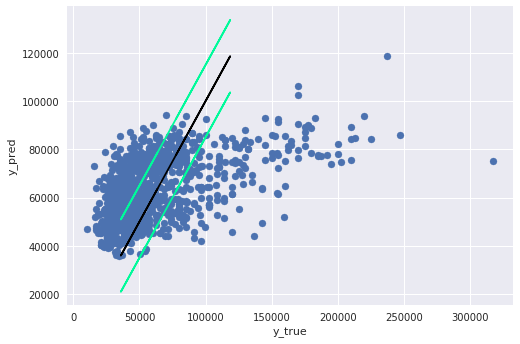

In [13]:
import matplotlib.pyplot as plt
with plt.style.context('seaborn'):
    ax = plt.scatter(y_true,y_pred)
    plt.plot(y_pred, y_pred, color='black')
    plt.plot(y_pred, y_pred-15000, color='mediumspringgreen')
    plt.plot(y_pred, y_pred+15000, color='mediumspringgreen')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_range_percentage_error(y_true, y_pred): 
    error = np.abs(y_true- y_pred)-10000
    error[error < 0] = 0
    return np.mean(error/y_true)*100

from sklearn import metrics

In [15]:
print('Mean Absolute Error: {0:.0f}'.format( metrics.mean_absolute_error(y_true, y_pred)))
print('Mean Absolute Percentage Error: {0:.1f}'.format(mean_absolute_percentage_error(y_true, y_pred)))
print('Mean Absolute Range Percentage Error: {0:.1f}'.format(mean_absolute_range_percentage_error(y_true, y_pred)))

print('Mean Squared Error: {0:.0f}'.format(metrics.mean_squared_error(y_true, y_pred)))
print('Root Mean Squared Error:{0:.0f}'.format(np.sqrt(metrics.mean_squared_error(y_true, y_pred))))
print('R2 Score:{0:.2f}'.format(np.sqrt(metrics.r2_score(y_true, y_pred))))


# print('Mean Absolute Error Train: {0:.0f}'.format( metrics.mean_absolute_error(y_train, y_pred_train)))
# print('Mean Absolute Percentage Error Train: {0:.1f}'.format(mean_absolute_percentage_error(y_train, y_pred_train)))
# print('Mean Absolute Range Percentage Error Train: {0:.1f}'.format(mean_absolute_range_percentage_error(y_train, y_pred_train)))
# print('R2 Score Train :{0:.2f}'.format(np.sqrt(metrics.r2_score(y_train, y_pred_train))))



Mean Absolute Error: 24561
Mean Absolute Percentage Error: 45.9
Mean Absolute Range Percentage Error: 27.3
Mean Squared Error: 1159796190
Root Mean Squared Error:34056
R2 Score:0.47
